In [2]:
%load_ext autoreload
%autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import pyforfluids as pff
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "IBM Plex Serif"
})
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

import pandas as pd
import chemicals
float64 = "float64"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
methane_isot = pd.read_csv("methaneiso.csv")

In [4]:
t = 170.0

methane =    chemicals.CAS_from_any("methane")
methane_tc = np.array([chemicals.critical.Tc(methane)])
methane_pc = np.array([chemicals.critical.Pc(methane)])/1e5
methane_w =  np.array([chemicals.acentric.omega(methane)])

kij = [
    [0.0],
    [0.0]
]
lij = kij
z = np.array([1.0])

methane_mixrule = pff.models.mixingrules.ClassicVdW(kij, lij)
methane_armodel = pff.models.cubic.PR76(
    methane_tc, methane_pc, methane_w, methane_mixrule
)
methane = pff.models.system.System(armodel=methane_armodel)

vs = methane_isot["v"].values
ps = np.array([methane.pressure(z, vi, t) for vi in vs[::100]])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


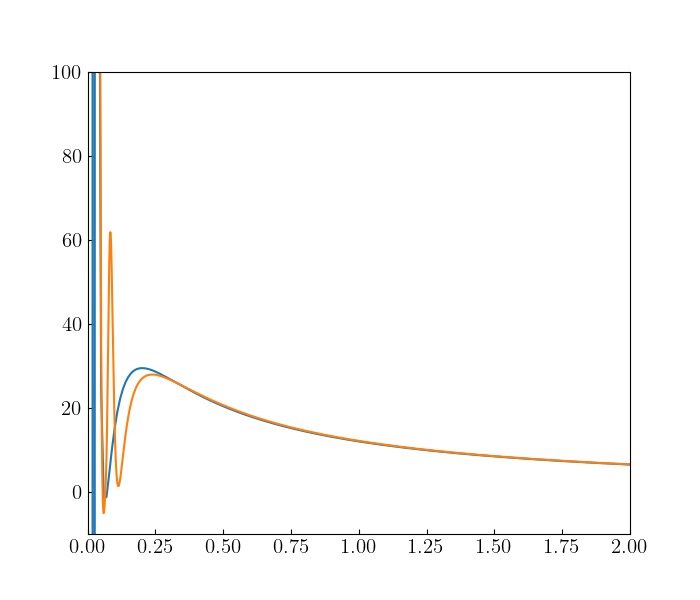

170.0

In [5]:
%matplotlib widget
plt.gcf().clf()

plt.plot(vs[::100], ps)
plt.plot(methane_isot["v"], methane_isot["pressure"]/1e5)

plt.xlim(0, 2)
plt.ylim(-10, 100)
plt.show()

t

In [11]:
v, it = methane.volume(z, 20, t, root="gas")
v, methane.pressure(z, v, t)

(Array(0.51626222, dtype=float64), Array(19.99953908, dtype=float64))

In [3]:
#components = ["methane", "ethane"]
components = ["Methane", "Ethane", "propane", "butane", "pentane", "hexane", "heptane", "octane", "nonane", "decane", "undecane", "dodecane", "tridecane", "tetradecane", "pentadecane", "hexadecane", "heptadecane", "octadecane", "nonadecane", "eicosane", "isobutane", "isopentane", "isooctane", "2,3-Dimethylbutane", "2-Methylpentane", "2,3-Dimethylpentane", "2,3,3-Trimethylpentane", "2,2,4-Trimethylpentane", "propylene"]
tc, pc, w = [], [], []
for component in components:
    data = chemicals.CAS_from_any(component)
    tc.append(chemicals.critical.Tc(data))
    pc.append(chemicals.critical.Pc(data))
    w.append(chemicals.acentric.omega(data))


kij = np.zeros((len(components), len(components)))

lij = 0 * 1.5*kij

z = np.linspace(1/len(components), 1, len(components))
p = 2.0
v = 100.0
t = 160.0

tc = np.array(tc, dtype=float64)
pc = np.array(pc, dtype=float64)/1e5
w = np.array(w, dtype=float64)

# Setup Mixing Rule
mixrule = pff.models.mixingrules.ClassicVdW(kij, lij)

# Setup the PR76 model
armodel = pff.models.cubic.PR76(tc, pc, w, mixrule)

# Setup the whole thermodyanmic system
system = pff.models.system.System(armodel=armodel)

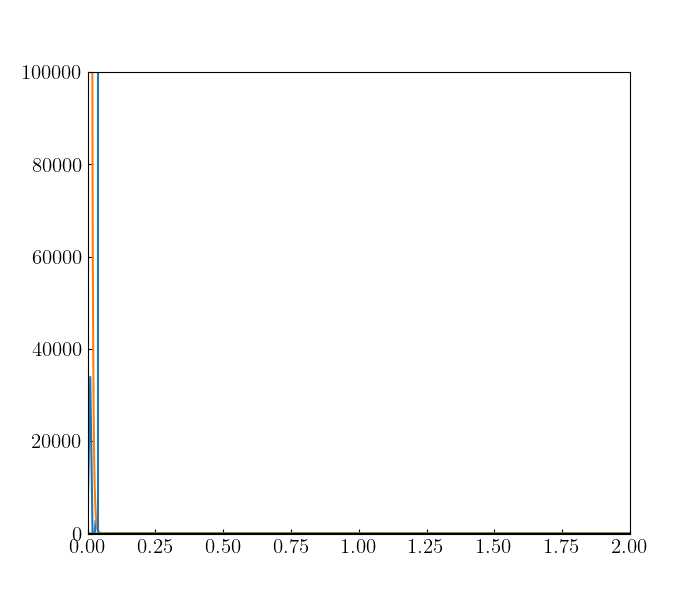

In [22]:
%matplotlib widget
pobj = 2
vs = np.linspace(0, 5, 10000)
ps = [system.pressure(z, v, t) for v in vs]

plt.plot(vs, ps)
plt.ylim(-1e2, 1e5)

plt.axvline(0.037898277402960964)
plt.axhline(pobj, color="black")
plt.show()

In [9]:
%%timeit
ps = np.linspace(1, 10, 100)

# v_gs = []
# v_ls = []

z = np.array([0.7, 0.3])

for pobj in ps:
    vg, it = system.volume(z, pobj, t)
    vl, it = system.volume(z, pobj, t, root="liquid")

    v_gs.append(vg)
    v_ls.append(vl)

NameError: name 'v_gs' is not defined

In [ ]:
plt.clf()
plt.title("Titul")
plt.plot(v_gs, ps)
plt.plot(v_ls, ps)
plt.show()

In [ ]:
system.armodel._tc

Array([190.564, 305.32 ], dtype=float64)

In [ ]:
armodel.residual_helmholtz(z, v, t), v, t

(Array(-0.00418112, dtype=float64), 100.0, 160.0)

In [ ]:
mixrule.mix_a(z, v, t, armodel.attractive_parameter(z, v, t))

Array(6.04894209, dtype=float64)

In [ ]:
mixrule.mix_b(z, v, t, armodel.repulsive_parameter(z, v, t))

Array(0.03641581, dtype=float64)

In [4]:
%timeit system.dar_dn(z, v, t)

The slowest run took 8.46 times longer than the fastest. This could mean that an intermediate result is being cached.
934 µs ± 721 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
len(system.dar_dn(z, v, t))

29

In [7]:
system.pressure(z, v, t)

Array(1.82212085, dtype=float64)